<a href="https://colab.research.google.com/github/taliafabs/sta365-winter2025/blob/main/sta365_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA365 Homework 4: Metropolis Hastings

# Question 1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*


In [56]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def joint_posterior(theta, tau, x, theta0, tau0, alpha, lambda_):
  """
  Computes the joint posterior p(theta, tau | x) ∝ p(x | theta, tau)p(theta)p(tau),
  ignoring the normalizing constant.
  """
  n = len(x)
  ssq = np.sum((x - theta)**2) / n
  # likelihood p(x | theta, tau)
  # likelihood = np.sqrt(tau) * np.exp(-0.5 * tau * ssq)
  likelihood = (tau**(n/2)) * np.exp(-0.5 * tau * ssq)
  # theta prior p(theta)
  theta_prior = np.exp(-0.5 * tau0 * (theta-theta0)**2)
  # tau prior p(tau)
  tau_prior = tau**(alpha-1) * np.exp(-lambda_ * tau)
  # joint posterior p(theta, tau | x) ∝ p(x | theta, tau)p(theta)p(tau)
  return likelihood * theta_prior * tau_prior


def metropolis_within_gibbs_sampler(x, theta_0, tau_0, alpha, lambda_, num_samples,
                            burn_in, prop_sd_theta):
  """
  Metropolis-within-Gibbs sampler
  """
  x = np.array(x)
  # Storing the samples
  theta_samples = np.zeros(num_samples)
  tau_samples = np.zeros(num_samples)

  # Initialization
  theta_curr = stats.norm(loc=theta_0, scale=1/lambda_).rvs()
  tau_curr = np.random.normal(tau_0, 1/np.sqrt(tau_0))


  for i in range(num_samples):
    #---------------------------------------------------------------------------
    # Metropolis-Hastings update for theta
    #---------------------------------------------------------------------------
    # draw the proposed theta
    theta_proposed = stats.norm.rvs(loc=theta_curr, scale=prop_sd_theta)
    # calculate the probability of acceptance
    p_theta_proposed = joint_posterior(theta_proposed, tau_curr, x, theta_0, tau_0, alpha, lambda_)
    p_theta_curr = joint_posterior(theta_curr, tau_curr, x, theta_0, tau_0, alpha, lambda_)
    # q_theta_proposed = stats.norm(loc=theta_curr, scale=prop_sd_theta).pdf(theta_proposed)
    q_theta_proposed = stats.norm.pdf(theta_proposed, loc=theta_curr, scale=prop_sd_theta)
    q_theta_curr = stats.norm.pdf(theta_curr, loc=theta_curr, scale=prop_sd_theta)
    theta_acceptance_ratio = (p_theta_proposed/p_theta_curr) * (q_theta_proposed/q_theta_curr)
    # theta_acceptance_ratio = compute_joint_posterior(theta_proposed, tau_curr, x, theta_0, tau_0, alpha, lambda_) / \
    #                     compute_joint_posterior(theta_curr, tau_curr, x, theta_0, tau_0, alpha, lambda_)*\
    #                     (stats.expon.pdf(theta_proposed)/stats.expon.pdf(theta_curr))
    prob_accept_theta = min(1, theta_acceptance_ratio)

    # decide whether or not to accept and act accordingly
    if np.random.rand() < prob_accept_theta:
      theta_curr = theta_proposed

    #---------------------------------------------------------------------------
    # Metropolis-Hastings update for tau
    #---------------------------------------------------------------------------
    tau_proposed = np.random.exponential(scale=1/lambda_)
    tau_acceptance_ratio = joint_posterior(theta_curr, tau_proposed, x, theta_0, tau_0, alpha, lambda_) / \
                      joint_posterior(theta_curr, tau_curr, x, theta_0, tau_0, alpha, lambda_) * \
                       (stats.expon.pdf(tau_curr)/stats.expon.pdf(tau_proposed))
    prob_accept_tau = min(1, tau_acceptance_ratio)
    if np.random.rand() < prob_accept_tau:
      tau_curr = tau_proposed

    theta_samples[i] = theta_curr
    tau_samples[i] = tau_curr

  return theta_samples[burn_in:], tau_samples[burn_in:]

In [57]:
np.random.seed(123)

# generate data ~ N(50, 0.04)
theta_true = 50
tau_true = 0.04
var = 1 / np.sqrt(tau_true)
x = stats.norm.rvs(theta_true, var, size=50)

# hyperparameters
theta_0 = 0
tau_0 = 0.01
alpha = 1
lambda_ = 1

# Run the gibbs sampler w metropolis hastings
theta_samples, tau_samples = metropolis_within_gibbs_sampler(x, theta_0, tau_0, alpha, lambda_, num_samples=10000,
                            burn_in=300, prop_sd_theta=0.8)

<ipython-input-56-85d73089f586>:14: RuntimeWarning: overflow encountered in exp
  likelihood = (tau**(n/2)) * np.exp(-0.5 * tau * ssq)
<ipython-input-56-85d73089f586>:50: RuntimeWarning: invalid value encountered in scalar divide
  theta_acceptance_ratio = (p_theta_proposed/p_theta_curr) * (q_theta_proposed/q_theta_curr)
<ipython-input-56-85d73089f586>:14: RuntimeWarning: overflow encountered in scalar multiply
  likelihood = (tau**(n/2)) * np.exp(-0.5 * tau * ssq)


In [58]:
print("Theta posterior mean:", np.mean(theta_samples))
print("Tau posterior mean:", np.mean(tau_samples))

Theta posterior mean: -15.863063583705648
Tau posterior mean: -10.377882102049536


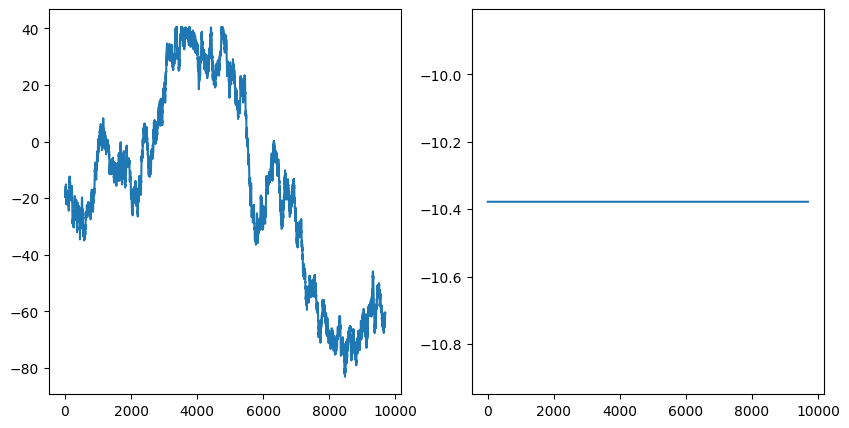

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(theta_samples)
ax[1].plot(tau_samples)
plt.show()

Bayesian inference:

In [61]:
theta_ci = np.quantile(theta_samples, [0.025, 0.975])
tau_ci = np.quantile(tau_samples, [0.025, 0.075])
print(f"Theta posterior credible interval: {theta_ci}")
print(f"Tau posterior credible interval: {tau_ci}")

Theta posterior credible interval: [-73.37004784  38.4656971 ]
Tau posterior credible interval: [-10.3778821 -10.3778821]


### Q2 from homework 3
Note: I didn't receive full marks for hw3q2, so I made changes and corrections based on where I lost marks and in comparison to the examples posted on Feb 4.


In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

priors = [
    {"alpha": 2, "lambda": 2, "theta_0": 0, "tau_0": 1 },
    {"alpha": 10, "lambda": 10, "theta_0": 0, "tau_0": 5 },
    {"alpha": 2, "lambda": 1, "theta_0": 5, "tau_0": 1}
]

def gibbs_sampler():


## Question 2
Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

In [62]:
def joint_posterior(theta, tau, x, theta_0, laplace, tau_0, alpha, lambda_):
  """
  Computes the joint posterior p(theta, tau | x) ∝ p(x | theta, tau)p(theta)p(tau),
  ignoring the normalizing constant.
  """
  n = len(x)
  ssq = np.sum((x - theta)**2) / n
  # likelihood p(x | theta, tau)
  likelihood = np.sqrt(tau) * np.exp(-0.5 * tau * ssq)
  # theta prior p(theta) with laplace parameter
  # theta_prior = np.exp(-0.5 * tau_0 * (theta - theta_0)**2)
  theta_prior = stats.gamma(alpha, scale=1/laplace).pdf(theta)
  # tau prior p(tau)
  tau_prior = tau**(alpha-1) * np.exp( -lambda_ * tau)
  # joint posterior p(theta, tau | x) ∝ p(x | theta, tau)p(theta)p(tau)
  return likelihood * theta_prior * tau_prior


def metropolis_within_gibbs_dependent_tau(x, theta_0, laplace, tau_0, alpha, lambda_, num_samples,
                            burn_in, prop_sd_theta, s):
  """
  Metropolis-within-Gibbs sampler adjusted to use the dependent proposal for tau.
  s is the new laplace parameter for the dependent proposal for tau.
  """
  x = np.array(x)
  # Storing the samples
  theta_samples = np.zeros(num_samples)
  tau_samples = np.zeros(num_samples)

  # Initialization
  theta_curr = stats.norm(loc=theta_0, scale=1/lambda_).rvs()
  tau_curr = stats.laplace(loc=tau_0, scale=laplace).rvs()


  for i in range(num_samples):
    #---------------------------------------------------------------------------
    # Metropolis update for theta
    #---------------------------------------------------------------------------
    # update: use the dependent proposal for tau
    theta_proposed = stats.norm.rvs(loc=theta_curr, scale=prop_sd_theta)

    # determine the acceptance ratio
    p_theta_proposed = joint_posterior(theta_proposed, tau_curr, x, theta_0, laplace, tau_0, alpha, lambda_)
    p_theta_curr = joint_posterior(theta_curr, tau_curr, x, theta_0, laplace, tau_0, alpha, lambda_)
    q_theta_proposed = stats.expon.pdf(theta_proposed)
    q_theta_curr = stats.expon.pdf(theta_curr)
    theta_acceptance_ratio = (p_theta_proposed/p_theta_curr) * (q_theta_proposed/q_theta_curr)

    # compute probability of accepting proposed theta
    prob_accept_theta = min(1, theta_acceptance_ratio)

    if np.random.rand() < prob_accept_theta: # decide whether to accept or reject proposal
      theta_curr = theta_proposed # if accepted update the value of theta!

    #---------------------------------------------------------------------------
    # Metropolis update for tau
    #---------------------------------------------------------------------------
    tau_proposed = stats.truncnorm.rvs(a=-tau_curr/s, b=np.Inf, loc=tau_curr, scale=s)

    pos_tau_proposed = joint_posterior(theta_curr, tau_proposed, x, theta_0, laplace, tau_0, alpha, lambda_)
    pos_tau_curr = joint_posterior(theta_curr, tau_curr, x, theta_0, laplace, tau_0, alpha, lambda_)
    q_tau_proposed = stats.truncnorm.pdf(tau_proposed, a=-tau_curr/s, b=np.Inf, loc=tau_curr, scale=s)
    q_tau_curr = stats.truncnorm.pdf(tau_curr, a=-tau_curr/s, b=np.inf, loc=tau_curr, scale=s)

    tau_acceptance_ratio = (pos_tau_proposed/pos_tau_curr) * (q_tau_curr/q_tau_proposed)
    prob_accept_tau = min(1, tau_acceptance_ratio)

    if np.random.rand() < prob_accept_tau: # decide whether to accept or reject proposal
      tau_curr = tau_proposed # update tau if accepted

    # add value of theta and tau to list of all theta and tau values
    theta_samples[i] = theta_curr
    tau_samples[i] = tau_curr

  return theta_samples[burn_in:], tau_samples[burn_in:]

In [53]:
np.random.seed(365)
theta_true = 50
tau_true = 0.04
var = 1 / np.sqrt(tau_true)
x = stats.norm.rvs(loc=theta_true, scale=var, size=50)
theta_0, alpha, lambda_, laplace = 0, 1, 1, 3

theta_samples, tau_samples = metropolis_within_gibbs_dependent_tau(x, theta_0, laplace, tau_0, alpha, lambda_, num_samples=10000,
                            burn_in=500, prop_sd_theta=1, s=0.2)

<ipython-input-49-45f92cc59dbd>:47: RuntimeWarning: invalid value encountered in scalar divide
  theta_acceptance_ratio = (p_theta_proposed/p_theta_curr) * (q_theta_proposed/q_theta_curr)
<ipython-input-49-45f92cc59dbd>:66: RuntimeWarning: invalid value encountered in scalar divide
  tau_acceptance_ratio = (pos_tau_proposed/pos_tau_curr) * (q_tau_curr/q_tau_proposed)
<ipython-input-49-45f92cc59dbd>:47: RuntimeWarning: divide by zero encountered in scalar divide
  theta_acceptance_ratio = (p_theta_proposed/p_theta_curr) * (q_theta_proposed/q_theta_curr)


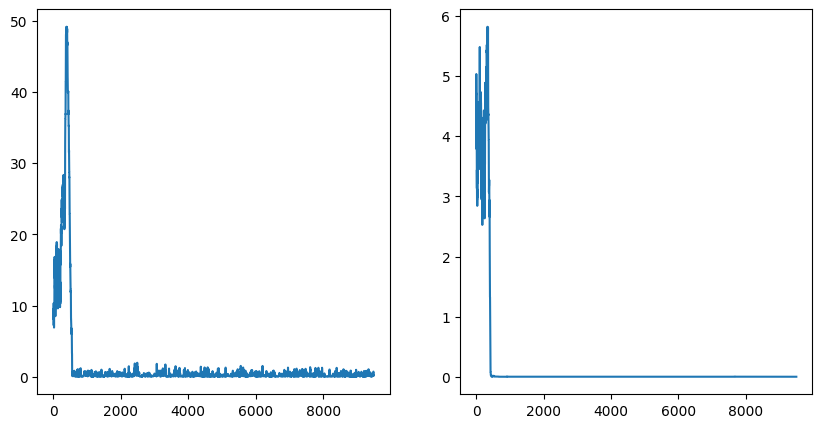

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(theta_samples)
ax[1].plot(tau_samples)
plt.show()

In [55]:
theta_ci = np.quantile(theta_samples, [0.025, 0.975])
tau_ci = np.quantile(tau_samples, [0.025, 0.075])
print(f"Theta posterior credible interval: {theta_ci}")
print(f"Tau posterior credible interval: {tau_ci}")

Theta posterior credible interval: [5.35610344e-03 2.15992441e+01]
Tau posterior credible interval: [0.00010628 0.00022913]


Discussion:
Full conditional disributions are not really necessary in Metropolis-Hastings Metropolis-Hastings allows us to sample from any proposal distribution and it doesn't require us to sample directly from the conditional posterior.

## Question 3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

The Metropolis-Hastings algorithm generates a Markov chain targeting the stationary distribution $p(x)$ using a proposal distribution $q(\tilde{x}^{(t)} | x^{(t-1)})$ \\

The acceptance probability is: $A(x^{(t-1)} \to \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)}) q(x^{(t-1)} | \tilde{x}^{(t)})}{p(x^{(t-1)}) q(\tilde{x}^{(t)} | x^{(t-1)})} \right)$ \\

Proposal distribution (symmetric): $q(\tilde{x}^{(t)} | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}} \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}} = q(\tilde{x}^{(t)} | x^{(t-1)}
$ \\

The ratio cancels:
$\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})} = 1.
$ \\

Target stationary distribution:
$p(x^{(t)}) = \left(\frac{1}{3}\right)^{1-x^{(t)}} \left(\frac{2}{3}\right)^{x^{(t)}}.
$

The acceptance probabilities are:
$A(0 \to 1) = \min \left( 1, \frac{p(1)}{p(0)} \right) = \min \left( 1, \frac{2/3}{1/3} \right) = \min(1, 2) = 1.
$ \\
$A(1 \to 0) = \min \left( 1, \frac{p(0)}{p(1)} \right) = \min \left( 1, \frac{1/3}{2/3} \right) = \min(1, 0.5) = 0.5.
$

Transition kernel probabilities: \\
$Pr(x^{(t)}=0 \to x^{(t+1)}=0) = 1 - \Pr(0 \to 1) = 1 - 1 = 0.5$ \\
$Pr(x^{(t)}=0 \to x^{(t+1)}=1) = \Pr(0 \to 1) = 0.5$ \\
$Pr(x^{(t)}=1 \to x^{(t+1)}=0) = \Pr(1 \to 0) = 0.25$ \\
$Pr(x^{(t)}=1 \to x^{(t+1)}=1) = 1 - \Pr(1 \to 0) = 1 - 0.25 = 0.75$ \\

That gives us transition kernel $K$:
\begin{align*}
K =
\begin{pmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{pmatrix}.
\end{align*}
